c:\Users\Stern\clip_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Stern\clip_env\lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

+-------------------------------------------------------------------------------------------------+------------------------------------------------------------+------------+------------------+
| Parent Module                                                                                   | Function                                                   | Replaced   | LRP compatible   |
+=================================================================================================+============================================================+============+==================+
| ('visual.conv1', <class 'torch.nn.modules.conv.Conv2d'>)                                        | -                                                          | -          |  ⁇               |
+-------------------------------------------------------------------------------------------------+------------------------------------------------------------+------------+------------------+
| ('visual.patch_dropout', <class '

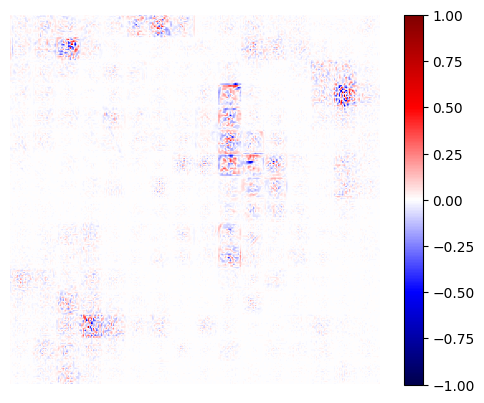

In [1]:
import torch
import open_clip
from PIL import Image
from zennit.composites import LayerMapComposite
import zennit.rules as z_rules
import lxt.functional as lf
from lxt.models.openclip import attnlrp
from zennit.image import imgify
import matplotlib.pyplot as plt

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Load OpenCLIP Model and Preprocess the Image
model, _, preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='laion2b_s34b_b88k')
model = model.to(device)
model.eval()

# Load an image and preprocess it
image_path = 'Black_cat.jpg'  # Update this path to your image
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

image.requires_grad_()  # Set requires_grad=True so that gradients can be tracked

# 2. Use Only the Image Encoder (skip text encoder and embeddings)
# The following applies LRP on the layers of the image encoder itself
image_features = model.encode_image(image)  # Forward pass through the image encoder

# 3. Apply LRP to the Image Encoder (No Text Involvement)
# Now, instead of focusing on embeddings, we focus on the internal layers of the image encoder
# We will trace the image encoder layers using attnlrp, and then perform LRP on them

x = torch.randn(1, 3, 224, 224, device=device)  # Dummy input for attnlrp registration
traced_model = attnlrp.register(model, dummy_inputs={'image': x}, verbose=True)

# 4. Apply LRP on Conv2d and Linear Layers inside the Image Encoder
# Register Gamma LRP rules for Conv2D and Linear layers
zennit_comp = LayerMapComposite([
    (torch.nn.Conv2d, z_rules.Gamma(0.5)),  # Gamma rule for Conv2D layers
    (torch.nn.Linear, z_rules.Gamma(0.5))   # Gamma rule for Linear layers
])

zennit_comp.register(traced_model)

# 5. Perform Backward Pass for LRP
# Sum the output features from the image encoder (these aren't final embeddings, but layer activations)
image_features.sum().backward()

# 6. Extract the relevance from image.grad (gradient as relevance)
heatmap = image.grad[0].sum(0)
heatmap = heatmap / abs(heatmap).max()  # Normalize the heatmap

# 7. Save or Display the Heatmap
imgify(heatmap.cpu().numpy(), vmin=-1, vmax=1).save('lrp_heatmap.png')

# Display the heatmap using matplotlib
plt.imshow(heatmap.cpu(), cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('off')
plt.show()

# Cleanup: Remove the registered Zennit composite after use
zennit_comp.remove()

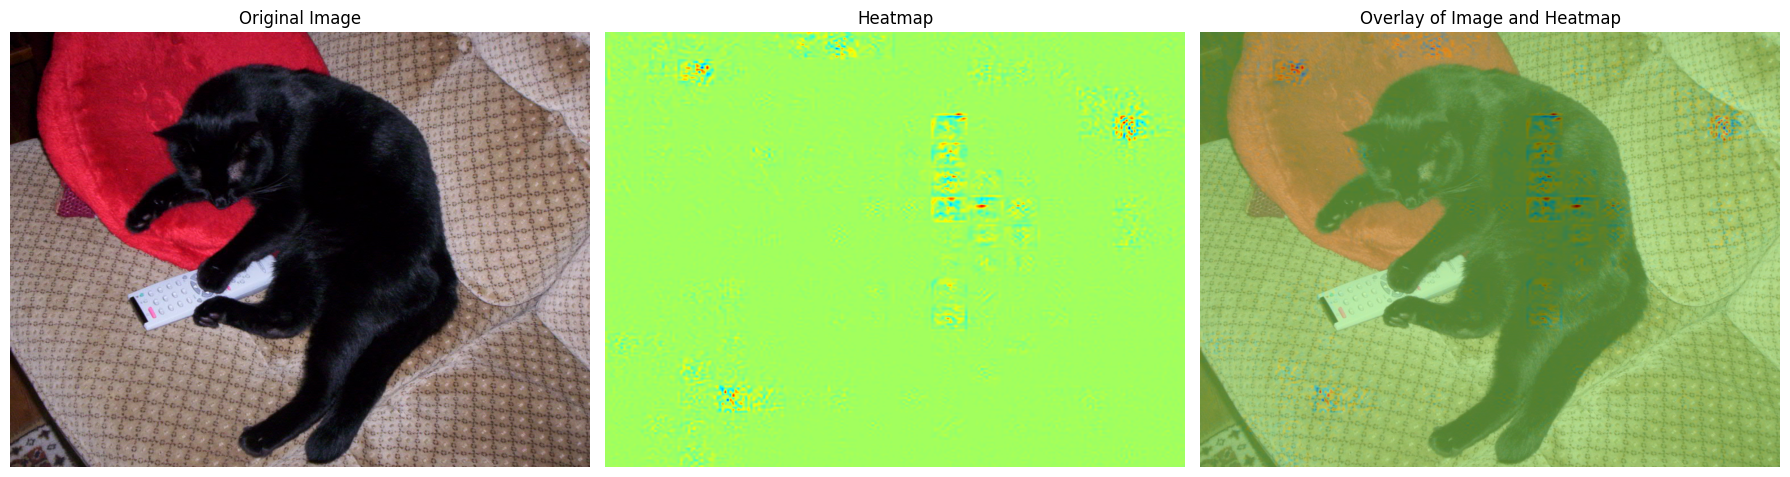

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_path = 'Black_cat.jpg'  # Update this path to your image
original_image = Image.open(image_path)

# Convert heatmap to a numpy array
heatmap_np = heatmap.cpu().numpy()

# Convert original image from PIL to a numpy array
original_image_np = np.array(original_image)

# Resize the heatmap to match the original image dimensions
heatmap_resized = cv2.resize(heatmap_np, (original_image_np.shape[1], original_image_np.shape[0]))

# Normalize the heatmap to range [0, 255] for visualization
heatmap_normalized = np.uint8(255 * (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min()))

# Apply a colormap to the heatmap
heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image using alpha blending
alpha = 0.5  # Adjust the transparency
overlay = cv2.addWeighted(original_image_np, 1 - alpha, heatmap_colored, alpha, 0)

# Display the original image, heatmap, and overlay side by side
plt.figure(figsize=(18, 6))

# Plot the Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

# Plot the Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap_colored, cmap='jet')
plt.title("Heatmap")
plt.axis('off')

# Plot the Overlay of Image and Heatmap
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay of Image and Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()
